In [86]:
import lzma
import json
import zipfile
import dataclasses
from pathlib import Path
from types import SimpleNamespace

import msgpack
import numpy as np
import attrs
import matplotlib.pyplot as plt
import pandas as pd

from arc25 import symmetry, tools as arc25_tools, dataset
from arc25 import serialisation

In [5]:
proj_root = Path("..").resolve()
data_root = proj_root / "data"
model_dir = data_root / "models"
trace_dir = data_root / "traces"

In [11]:
all_known_tasks = await dataset.Dataset.from_binary(data_root / "repack/all-challenges.cbor.xz")

In [81]:
with zipfile.ZipFile(data_root/"external/arc-prize-2025.zip","r") as zfh:
    eval_sols = json.load(zfh.open("arc-agi_evaluation_solutions.json"))
    train_sols = json.load(zfh.open("arc-agi_training_solutions.json"))
reference_solutions = eval_sols | train_sols
reference_solutions = {k:v for k,v in expected_solutions.items() if k in main_dataset.challenges}
len(reference_solutions), len(main_dataset.challenges)

(240, 240)

In [87]:
main_dataset = await dataset.Dataset.load_from_json(
    root=data_root/"external/arc-prize-2025.zip",
    challenges="arc-agi_test_challenges.json",
    id="main",
)
main_dataset = attrs.evolve(
    main_dataset,
    challenges = {
        k: attrs.evolve(v, test=[
            dataclasses.replace(ex,output=np.array(s,"i1"))
            for ex,s in zip(v.test,reference_solutions[k])
        ])
        for k,v in main_dataset.challenges.items()
    }
)

In [93]:
with open(trace_dir / "submission.json", "rt") as fh:
    submission = json.load(fh)

In [101]:
with open(trace_dir / "submission-2.json", "rt") as fh:
    submission2 = json.load(fh)

00576224: False
007bbfb7: True
009d5c81: False
00d62c1b: True
00dbd492: False


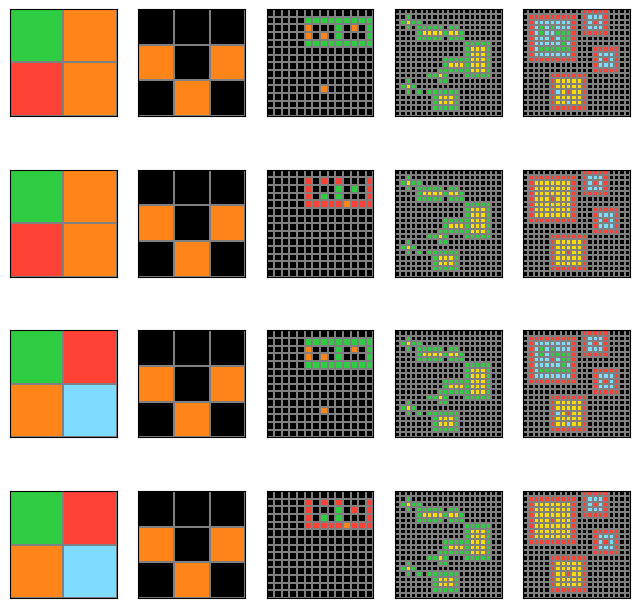

In [102]:
fig, axes = plt.subplots(4,5,figsize=(8,8))
for k,axe in zip(sorted(set(submission) | set(submission2))[:10],axes.T):
    print(f"{k}: {submission[k] == submission2[k]}")
    for axe2,s in zip(axe.reshape(2,2),[submission,submission2]):
        for ax,att in zip(axe2,s[k][0].values()):
            img = np.array(att)
            arc25_tools.show_image(img,ax=ax)

In [103]:
correctness = {}
for k,v in submission.items():
    all_ok = True
    for actual,expected in zip(v,main_dataset.challenges[k].test):
        ok = False
        for attempt in actual.values():
            attempt = np.array(attempt,"i1")
            if attempt.shape != expected.output.shape:
                continue
            if np.any(attempt != expected.output):
                continue
            ok = True
            break
        all_ok = all_ok and ok
    correctness[k] = all_ok
print(f"{np.mean(list(correctness.values()))*100:.1f} %")   
for k,v in dict(train=train_sols,eval=eval_sols).items():
    print(f"{k}: {np.mean([vv for i in v if (vv:=correctness.get(i) is not None)])*100:.1f} %")     

12.1 %
train: 100.0 %
eval: nan %


In [104]:
with lzma.LZMAFile(trace_dir/"latent-pgms.msgpack.xz","rb") as fh:
    latent_pgm_data = serialisation.deserialise(msgpack.loads(fh.read()))
latent_pgms = latent_pgm_data["latent_program_embeddings"]
latent_pgms.shape

(240, 8, 8, 768)

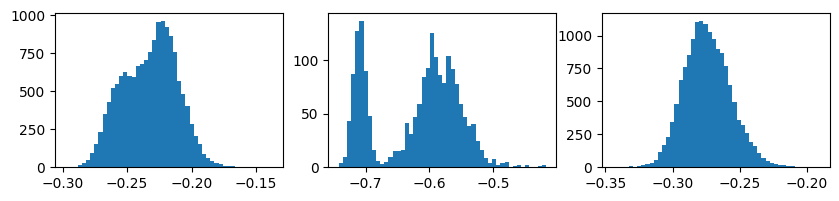

In [105]:
mlpm = latent_pgms.mean(axis=1,keepdims=True)
dlpm = latent_pgms - mlpm
fig, axes = plt.subplots(1,3,figsize=(10,2))
for ax, v in zip(axes,[latent_pgms, mlpm, dlpm]):
    _ = ax.hist(np.log10(np.linalg.norm(v,axis=-1).ravel()),bins=50)

In [106]:
with lzma.LZMAFile(trace_dir/"solutions.msgpack.xz","rb") as fh:
    tmp = serialisation.deserialise(msgpack.loads(fh.read()))
solutions = {}
for k,v in tmp.items():
    c = main_dataset.challenges[v.pop("challenge")]
    solutions[k] = SimpleNamespace(challenge=c,**v)

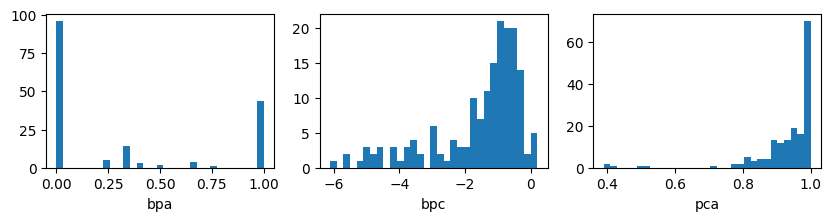

In [107]:
sstats = pd.DataFrame([dict(
    id = sol.challenge.id,
    bpa = sol.pair_accuracy.max(),
    bpc = sol.pair_crossentropy.min(),
    pca = sol.cell_accuracy.max(),
    smatch = all(
        ex.input.shape == ex.output.shape
        for ex in 
        sol.challenge.train
    ),
) for sol in solutions.values()]).set_index("id")

fig, axes = plt.subplots(1,3,figsize=(10,2))
for ax, c in zip(axes,sstats.columns):
    v = sstats.loc[sstats.smatch,c]
    if c.endswith("c"):
        v = np.log10(v)
    _ = ax.hist(v,bins=31)
    ax.set_xlabel(c)

(4, 8, 30, 30, 10)
(4, 8, 30, 30, 10)
(5, 8, 30, 30, 10)
(4, 8, 30, 30, 10)
(4, 8, 30, 30, 10)
(3, 8, 30, 30, 10)
(4, 8, 30, 30, 10)
(6, 8, 30, 30, 10)


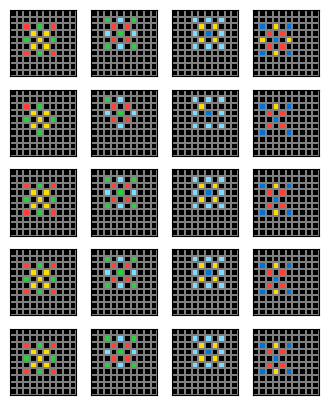

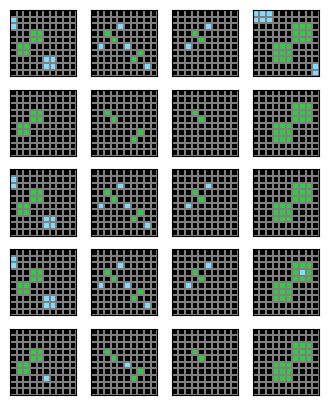

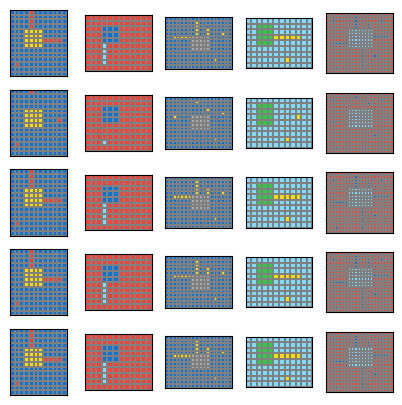

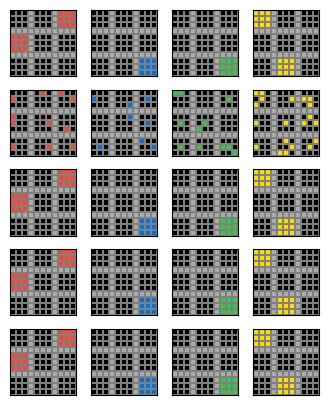

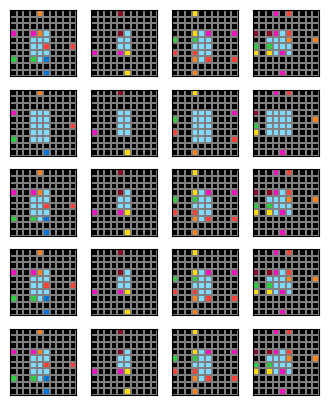

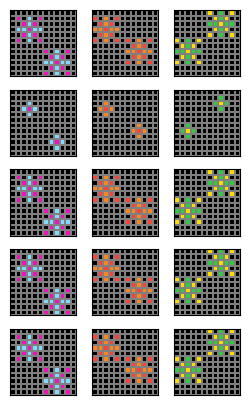

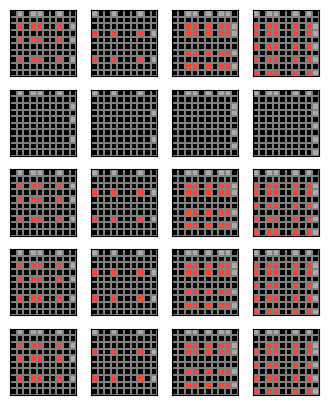

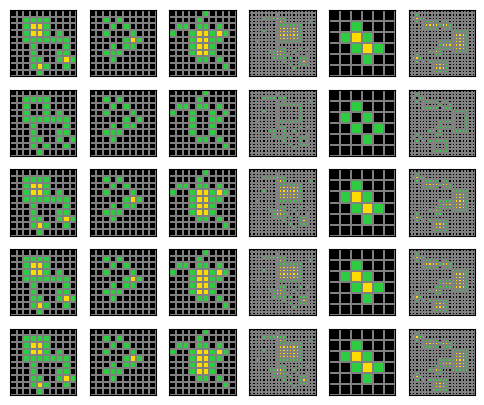

In [112]:
preds = sorted(
    solutions.values(),
    key=lambda p: p.pair_crossentropy.min() if all(
        ex.input.shape == ex.output.shape
        for ex in 
        p.challenge.train
    ) else np.inf
)[:8]

M = 3+2
for pred in preds:
    logits = np.concatenate([pred.train_logits,pred.test_logits],axis=0)
    print(logits.shape)
    N = logits.shape[0]
    idx = np.argsort(pred.pair_crossentropy)[:M-2]
    s = 1
    fig, axes = plt.subplots(M,N,figsize=(N*s,M*s))
    
    for trip,log,axe in zip(pred.challenge.get_empty_eval_triples(),logits,axes.T):
        ax = axe[1]
        arc25_tools.show_image(trip.input,ax=ax)
        if trip.expected is not None:
            ax = axe[0]
            arc25_tools.show_image(trip.expected,ax=ax)
            h,w = trip.expected.shape
        else:
            h,w = trip.input.shape
        for ax,lg in zip(axe[2:],log[idx]):
            if False:
                arc25_tools.show_prediction(jax.nn.softmax(lg[:h,:w,:],axis=-1),ax=ax)
            else:
                arc25_tools.show_image(np.argmax(lg[:h,:w,:],axis=-1),ax=ax)